# Data pre processing

In [216]:
import pandas as pd 
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np 
import torch.nn.functional as F 

In [217]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

In [218]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [219]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [220]:
def cabin_location(df):
    df['Cabin_deck'] = df['Cabin'].apply(lambda x: x.split('/')[0])
    df['Cabin_number'] = df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
    df['Cabin_side'] = df['Cabin'].apply(lambda x: x.split('/')[2])
    return df

In [221]:
train_data = cabin_location(train_data)
test_data = cabin_location(test_data)
train_data.drop(['Cabin', 'PassengerId', 'Name'], axis=1, inplace=True)
test_ids = test_data['PassengerId']
test_data.drop(['Cabin', 'PassengerId', 'Name'], axis=1, inplace=True)

In [222]:
train_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_deck,Cabin_number,Cabin_side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608,S


In [223]:
from sklearn.calibration import LabelEncoder


label_encoder = LabelEncoder()
for col in train_data.columns:
    if train_data[col].dtype == 'object' or train_data[col].dtype =='bool':
        train_data[col] = label_encoder.fit_transform(train_data[col])
        if col != 'Transported':
            test_data[col] = label_encoder.transform(test_data[col])

In [224]:
train_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_deck,Cabin_number,Cabin_side
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,5,0,1
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,0,1
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,0,1
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,0,98,0
8689,0,1,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,6,1499,1
8690,0,0,2,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,6,1500,1
8691,1,0,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,4,608,1


# Splitting into test and train

In [225]:
X_train = train_data.drop(['Transported'], axis=1)
y_train = train_data['Transported']

In [226]:
y_train

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 6606, dtype: int64

In [227]:
y_train = pd.get_dummies(y_train).astype(int)

In [228]:
y_train

,0,1
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
8688,1,0
8689,1,0
8690,0,1
8691,1,0


In [229]:
from sklearn.model_selection import train_test_split


x_t, x_val, y_t, y_val = train_test_split(X_train, y_train, stratify=y_train,
                                          test_size=0.3, random_state=42)


In [230]:
x_t = torch.tensor(x_t.values, dtype=torch.float32)
y_t = torch.tensor(y_t.values, dtype=torch.float32)
x_val = torch.tensor(x_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

In [231]:
dataset = TensorDataset(x_t, y_t)
loader = DataLoader(dataset, batch_size=8)

In [234]:
from typing import Any


class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()

        self.input_layer = nn.Linear(input_size, 100)
        self.hidden_layer = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, output_size)

    
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        x = F.sigmoid(x)
        return x

In [245]:
F.sigmoid(torch.rand((1,3)))

tensor([[0.5546, 0.5218, 0.6853]])

In [247]:
model = NN(x_val.shape[1], y_val.shape[1])

In [248]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=0.05)

In [249]:
torch.nn.utils.clip_grad_norm_(model.parameters(), 1, norm_type=2.0, error_if_nonfinite=False, foreach=None)

tensor(0.)

In [250]:
train_losses = []
val_losses = []
for epoch in range(10):
    running_loss = 0
    for n, batch in enumerate(loader):
        X, y = [x for x in batch]
        
        output = model(X)
        print(output)
        loss = nn.BCELoss()(output, y)
        print(loss.item())
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
    train_losses.append(running_loss/(n+1))
    with torch.no_grad():
        output = model(x_val)
        loss = nn.BCELoss()(output, y_val)
        val_losses.append(loss.item())


tensor([[9.9995e-01, 6.4064e-09],
        [7.9858e-02, 1.8009e-06],
        [1.0000e+00, 1.7866e-13],
        [3.7169e-09, 8.1766e-01],
        [1.0000e+00, 0.0000e+00],
        [9.9898e-01, 1.7060e-01],
        [1.0000e+00, 0.0000e+00],
        [4.6824e-01, 4.3229e-02]], grad_fn=<SigmoidBackward0>)
18.673851013183594
tensor([[9.9998e-01, 3.1185e-18],
        [6.6096e-01, 2.6006e-02],
        [8.7557e-01, 1.0872e-03],
        [9.9991e-01, 1.8233e-11],
        [9.5485e-01, 4.0792e-11],
        [9.9986e-01, 3.8667e-24],
        [1.0000e+00, 8.8276e-16],
        [1.0000e+00, 3.4912e-21]], grad_fn=<SigmoidBackward0>)
4.063128471374512
tensor([[1.0000e+00, 1.9773e-35],
        [2.5258e-04, 2.8250e-03],
        [3.8247e-01, 1.0486e-01],
        [2.7260e-09, 4.6606e-06],
        [6.7943e-30, 7.1123e-19],
        [1.0000e+00, 0.0000e+00],
        [8.6561e-01, 1.1298e-12],
        [5.9225e-26, 9.1605e-17]], grad_fn=<SigmoidBackward0>)
6.233981132507324
tensor([[1.0000e+00, 1.1299e-14],
        

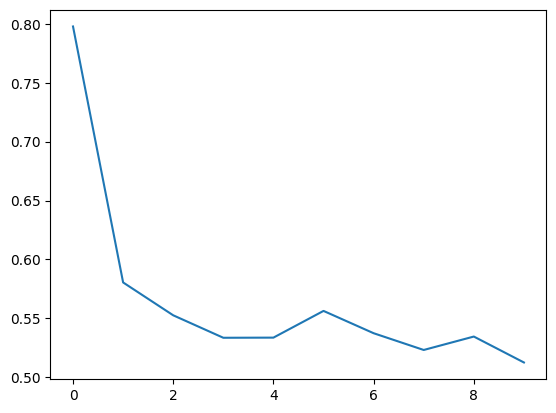

In [251]:
import matplotlib.pyplot as plt
plt.plot(val_losses)

In [252]:
with torch.no_grad():
    output = model(x_val)

In [253]:
output

tensor([[3.2506e-01, 6.7602e-01],
        [7.6537e-01, 2.3387e-01],
        [8.4178e-01, 1.5844e-01],
        ...,
        [7.5048e-01, 2.5030e-01],
        [3.3700e-01, 6.6427e-01],
        [1.0000e+00, 5.4426e-07]])

In [254]:
torch.round(output)

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])

In [255]:
train_acc = torch.sum(y_val == torch.round(output))

In [258]:
train_acc / (y_val.shape[0]*2)

tensor(0.7856)

In [259]:
y_val == torch.round(output)

tensor([[True, True],
        [True, True],
        [True, True],
        ...,
        [True, True],
        [True, True],
        [True, True]])